# Set up

In [2]:
import numpy as np
import sys
import math as m
import pickle as pickle
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro,f_oneway,friedmanchisquare,rankdata
import statsmodels.stats.multitest as smm
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
from matplotlib.lines import Line2D
from itertools import combinations

# auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer

from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *
import plotting_variables
from plotting_variables import TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE, MARKER_SIZE, python_colors, colors, yfill, ufill, gfill, rfill, bfill

In [4]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [51]:
# CGANGE THIS TO YOUR OWN PATH
path = "C:\\Users\\amber\\OneDrive - UW\\Sensorimotor Fusion\\pickles\\"  # for Amber's laptop
# path = r'/Users/amberchou/Library/CloudStorage/OneDrive-UW(2)/meta/eye_tracking/pickles/pickles_11_subjects/'  # for Amber's mac

# Load the array from the file
with open(path+'multimodal_data.pkl', 'rb') as file:
    Rs,Ds,MDs,Us,U0s,U1s,Ys,rs,ds,mds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd,F,B,F0,F1,B0,B1 = pickle.load(file)

In [60]:
rs = rs.astype(float)

In [52]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
# conditions = ['0','0.25','0.5','0.75','1']
conditions = ['0','25','50','75','100']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# check data

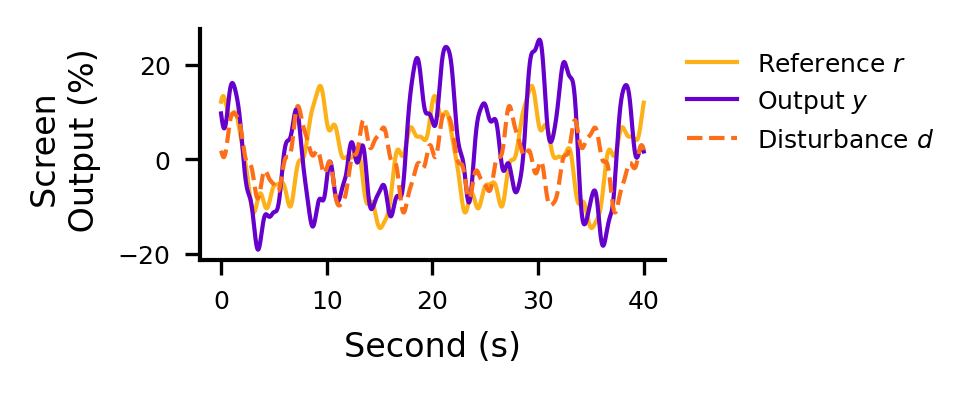

In [25]:
# example trial
fig,ax = plt.subplots(figsize=(2,1),dpi=300)
ax.plot(t,rs[0,0,-1,:]*100,label = 'Reference '+r'$r$',color = colors['r'])
ax.plot(t,ys[0,0,-1,:]*100,label = 'Output '+r'$y$',color = colors['y'])
ax.plot(t,mds[0,0,-1,:]*100,linestyle = '--',label = 'Disturbance '+r'$d$',color = colors['d'])
ax.set_ylabel('Screen \n Output (%)')
ax.set_xlabel('Second (s)')
ax.legend(bbox_to_anchor = (1,1),  frameon=False)
# ax.legend(loc = 'upper center', ncol=3, frameon=False)
# ax.legend(bbox_to_anchor = (0.7,0.9), ncol=3, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# fig,ax = plt.subplots(figsize=(2,1),dpi=300)
# ax.plot(t,rs[0,0,-1,:]*100,label = 'r',color = 'black')
# ax.plot(t,ys[0,0,-1,:]*100,label = 'y',color = colors['y'])
# ax.plot(t,mds[0,0,-1,:]*100,linestyle = '--',label = 'd',color = 'black')
# ax.set_ylabel('Screen \n Output (%)')
# ax.set_xlabel('Second (s)')
# ax.legend(bbox_to_anchor = (1,1),  frameon=False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.show()

# Simuli

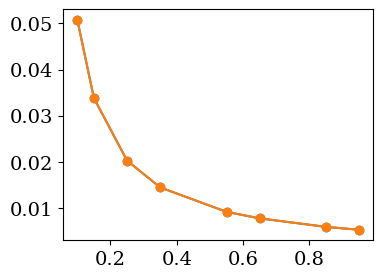

In [14]:
fig,ax = plt.subplots(figsize=(4,3))
Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[::2] = Rs[0,0,-1,IX][::2] 
Stimuli[1::2] = Rs[0,0,-2,IX][1::2] 
ax.plot(freqs,np.abs(Stimuli),'-o')

Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[1::2] = MDs[0,0,-1,IX][1::2] 
Stimuli[::2] = MDs[0,0,-2,IX][::2] 
ax.plot(freqs,np.abs(Stimuli),'-o')
plt.show()

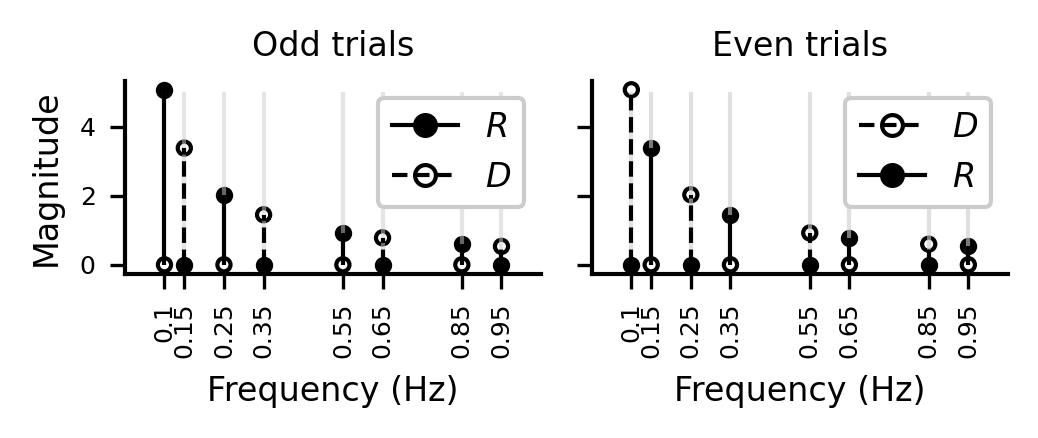

In [44]:
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
sub = 0
cond = 0

fig,axs = plt.subplots(1, 2,sharex = True,sharey = True,figsize=(3.5, 1.5),dpi=300) 
ax = axs[0]
trial = 1
ax.vlines(freqs,ymin=-0.001, ymax=5,linewidth=1, color='0.8',alpha = 0.5)
R = np.abs( Rs[sub,cond,trial,IX]*100 )
D = np.abs( MDs[sub,cond,trial,IX]*100 )
ax.scatter(freqs,R, color='black',label=r'$R$_{odd}',s=10)
ax.scatter(freqs,D, color='black',label=r'$D_{even}$',facecolors='none',s=10)
ax.vlines(freqs,np.zeros((len(IX),)),R,color='black')
ax.vlines(freqs,np.zeros((len(IX),)),D,linestyles='--',color='black')
ax.set_xlim((0,21*base_freq))
# ax.set_ylim((-0.2,6))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
legend_elements = [Line2D([0], [0], marker='o', color='black' ,label=r'$R$', markersize=MARKER_SIZE),
                   Line2D([0], [0], ls = '--',marker='o',color='black', label=r'$D$',markerfacecolor='none', markersize=MARKER_SIZE)]
ax.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=True, prop={'size': SMALL_SIZE},facecolor = 'white',framealpha = 1)
ax.set_title('Odd trials')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axs[1]
trial = 0
ax.vlines(freqs,ymin=-0.001, ymax=5,linewidth=1, color='0.8',alpha = 0.6)
R = np.abs( Rs[sub,cond,trial,IX]*100 )
D = np.abs( MDs[sub,cond,trial,IX]*100 )
ax.scatter(freqs,R, color='black',label=r'$R$_{odd}',s=10)
ax.scatter(freqs,D, color='black',label=r'$D_{even}$',facecolors='none',s=10)
ax.vlines(freqs,np.zeros((len(IX),)),R,color='black')
ax.vlines(freqs,np.zeros((len(IX),)),D,linestyles='--',color='black')
ax.set_xlim((0,21*base_freq))
# ax.set_ylim((-0.2,6))
ax.set_xlabel('Frequency (Hz)')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
legend_elements = [Line2D([0], [0], ls = '--', marker='o',color='black', label=r'$D$',markerfacecolor='none',markersize=MARKER_SIZE),
                   Line2D([0], [0], marker='o', color='black' ,label=r'$R$',markersize=MARKER_SIZE)]
ax.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=True, prop={'size': SMALL_SIZE},facecolor = 'white',framealpha = 1)
ax.set_title('Even trials')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# fig.savefig('stimuli.svg')
plt.show()

# Performance

Hypothesis: any of the conditions (25, 50, or 75) is better than condition 0 or condition 100. So six pairwise comparisons:
25 vs. 0
50 vs. 0
75 vs. 0
25 vs. 100
50 vs. 100
75 vs. 100

In [45]:
last_trials = trial_num - 5 # removing the first 5 trials 

In [ ]:
def stats_test(datas):
    # Compute residuals (observed - condition mean)
    residuals_0 = datas[0] - np.mean(datas[0])
    residuals_25 = datas[1] - np.mean(datas[1])
    residuals_50 = datas[2] - np.mean(datas[2])
    residuals_75 = datas[3] - np.mean(datas[3])
    residuals_100 = datas[4] - np.mean(datas[4])

    # Combine residuals from all conditions
    all_residuals = np.concatenate([residuals_0, residuals_25, residuals_50, residuals_75, residuals_100])

    # Perform Shapiro-Wilk test on residuals
    stat, p = shapiro(all_residuals)
    print(f'Shapiro-Wilk Test Statistic={stat:.4f}, p-value={p:.4f}')
    if p > 0.05:
        print("Residuals appear to be normally distributed (fail to reject H0).")
        stat, p = f_oneway(datas[0],datas[1],datas[2],datas[3],datas[4]) #see if p < 0.05, there is a significant difference
        print(f'One-way ANOVA Statistic={stat:.4f}, p-value={p:.4f}')
        if p <= 0.05:
            print('ANOVA Test: significant difference. Do paired t-tests')
            # post hoc test with correction
            comparisons = [
                ("0 vs. 100", datas[0], datas[4]),
                ("25 vs. 0", datas[1], datas[0]),
                ("50 vs. 0", datas[2], datas[0]),
                ("75 vs. 0", datas[3], datas[0]),
                ("25 vs. 100", datas[1], datas[4]),
                ("50 vs. 100", datas[2], datas[4]),
                ("75 vs. 100", datas[3], datas[4])
            ]
            p_values = []
            for name, cond1, cond2 in comparisons:
                stat, p = ttest_rel(cond1, cond2)
                p_values.append(p)
            # # Apply Bonferroni correction (dividing α by 6)
            # corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]
            # for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
            #     print(f'{name}: Raw p-value = {p_raw:.4f}, Bonferroni-corrected p-value = {p_corr:.4f}')

            # Apply Holm-Sidak Correction
            corrected_p_values = smm.multipletests(p_values, method='holm-sidak')[1]
            for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
                print(f'{name}: Raw p-value = {p_raw:.4f}, Holm-Sidak corrected p-value = {p_corr:.4f}')
    else:
        print("Residuals are NOT normally distributed (reject H0).") 
         # Perform Friedman test
        stat, p = friedmanchisquare(datas[0],datas[1],datas[2],datas[3],datas[4])
        print(f'Friedman Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference
        if p <= 0.05:
            print('Friedman Test: significant difference')
            # post hoc test with Wilcoxon signed-rank tests with Bonferroni correction
            comparisons = [
                ("0 vs. 100", datas[0], datas[4]),
                ("25 vs. 0", datas[1], datas[0]),
                ("50 vs. 0", datas[2], datas[0]),
                ("75 vs. 0", datas[3], datas[0]),
                ("25 vs. 100", datas[1], datas[4]),
                ("50 vs. 100", datas[2], datas[4]),
                ("75 vs. 100", datas[3], datas[4])
            ]
            p_values = []
            for name, cond1, cond2 in comparisons:
                stat, p = wilcoxon(cond1, cond2)
                p_values.append(p)
            # # Apply Bonferroni correction (dividing α by 6)
            # corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]
            # for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
            #     print(f'{name}: Raw p-value = {p_raw:.4f}, Bonferroni-corrected p-value = {p_corr:.4f}')

            # Apply Holm-Sidak Correction
            corrected_p_values = smm.multipletests(p_values, method='holm-sidak')[1]
            for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
                print(f'{name}: Raw p-value = {p_raw:.4f}, Holm-Sidak corrected p-value = {p_corr:.4f}')

        else:
            print('Friedman Test: no significant difference')

# if comparing every pairs (10 comarisons)

    # # post hoc test with Wilcoxon signed-rank tests with Bonferroni correction
    # pairs = list(combinations(range(len(datas)), 2))
    # p_values = []
    # pair_labels = []
    # for i, j in pairs:
    #     stat, p = wilcoxon(datas[i], datas[j])
    #     p_values.append(p)
    #     pair_labels.append(f"{conditions[i]} vs {conditions[j]}")

    # # Print uncorrected p-values
    # # for pair, p in zip(pair_labels, p_values):
    #     # print(f'Wilcoxon test {pair}: p-value={p:.4f}')

    # # Apply Bonferroni correction, divides the significance level (0.05) by the number of comparisons (10)
    # corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]

    # # Print Bonferroni-corrected p-values
    # print("\nBonferroni-Corrected P-values:")
    # for pair, p_corr in zip(pair_labels, corrected_p_values):
    #     print(f'{pair}: p-value={p_corr:.4f}')

### (1) time domain r-y

In [61]:
datas = []
for cond in range(condition_num):
    datas.append( np.mean((100*rs[:,cond,-last_trials:] - 100*ys[:,cond,-last_trials:])**2,axis = (1,2)) )#mean across all trials and timestamps
stats_test(datas)
TIME_DOMAIN_PERFORMANCE = datas

Shapiro-Wilk Test Statistic=0.6412, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=14.5067, p-value=0.0058
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.2769, Holm-Sidak corrected p-value = 0.7265
25 vs. 0: Raw p-value = 0.0256, Holm-Sidak corrected p-value = 0.1440
50 vs. 0: Raw p-value = 0.0012, Holm-Sidak corrected p-value = 0.0081
75 vs. 0: Raw p-value = 0.1070, Holm-Sidak corrected p-value = 0.4321
25 vs. 100: Raw p-value = 0.8904, Holm-Sidak corrected p-value = 0.9616
50 vs. 100: Raw p-value = 0.2769, Holm-Sidak corrected p-value = 0.7265
75 vs. 100: Raw p-value = 0.8040, Holm-Sidak corrected p-value = 0.9616


### (2) performance at non-stim freqs

In [62]:
datas = []
indices = np.setdiff1d(np.arange(0,40), IX) # non-stimulus freqs below 1hz
TF = 100*Ys[:,:,-last_trials:,indices] # R-Y below 1Hz, all freqs
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
FREQ_DOMAIN_PERFORMANCE = datas

Shapiro-Wilk Test Statistic=0.5905, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=16.9067, p-value=0.0020
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.9780, Holm-Sidak corrected p-value = 0.9780
25 vs. 0: Raw p-value = 0.0181, Holm-Sidak corrected p-value = 0.0871
50 vs. 0: Raw p-value = 0.0043, Holm-Sidak corrected p-value = 0.0295
75 vs. 0: Raw p-value = 0.5245, Holm-Sidak corrected p-value = 0.9489
25 vs. 100: Raw p-value = 0.5245, Holm-Sidak corrected p-value = 0.9489
50 vs. 100: Raw p-value = 0.0043, Holm-Sidak corrected p-value = 0.0295
75 vs. 100: Raw p-value = 0.5614, Holm-Sidak corrected p-value = 0.9489


In [198]:
# datas = []
# indices = IX #IX[:3] # non-stimulus freqs below 0.25hz 
# TF = 100*Rs[:,:,-last_trials:,indices] - 100*Ys[:,:,-last_trials:,indices] # R-Y below 0.25 Hz, all freqs
# for cond in range(condition_num):
#     datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
# stats_test(datas)
# ALL.append(datas)

### (3) Tyr reference tracking

In [63]:
# Tyr - 1
datas = []
TF = Tyr[:,:,-last_trials:,:3] - 1 # at stimulated freqs
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
REF_TRACKING_PERFORMANCE = datas

Shapiro-Wilk Test Statistic=0.9155, p-value=0.0001
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=25.3333, p-value=0.0000
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.0009, Holm-Sidak corrected p-value = 0.0043
25 vs. 0: Raw p-value = 0.0001, Holm-Sidak corrected p-value = 0.0004
50 vs. 0: Raw p-value = 0.0001, Holm-Sidak corrected p-value = 0.0004
75 vs. 0: Raw p-value = 0.0043, Holm-Sidak corrected p-value = 0.0170
25 vs. 100: Raw p-value = 0.7615, Holm-Sidak corrected p-value = 0.8694
50 vs. 100: Raw p-value = 0.3028, Holm-Sidak corrected p-value = 0.6611
75 vs. 100: Raw p-value = 0.6387, Holm-Sidak corrected p-value = 0.8694


### (4) Ty(Md) disturbance rejection 

In [64]:
# Ty(Md)
datas = []
TF = Tyd[:,:,-last_trials:,:3]* (1/M)[:3] # Ty(Md) at stimulated freqs
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
DIS_RECTION_PERFORMANCE = datas

Shapiro-Wilk Test Statistic=0.9175, p-value=0.0001
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=23.6267, p-value=0.0001
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.0043, Holm-Sidak corrected p-value = 0.0212
25 vs. 0: Raw p-value = 0.0256, Holm-Sidak corrected p-value = 0.0748
50 vs. 0: Raw p-value = 0.0004, Holm-Sidak corrected p-value = 0.0030
75 vs. 0: Raw p-value = 0.0009, Holm-Sidak corrected p-value = 0.0051
25 vs. 100: Raw p-value = 0.0054, Holm-Sidak corrected p-value = 0.0213
50 vs. 100: Raw p-value = 0.1688, Holm-Sidak corrected p-value = 0.3091
75 vs. 100: Raw p-value = 0.8904, Holm-Sidak corrected p-value = 0.8904


### (5) Feedforward F-M^-1

In [65]:
datas = []
TF = F[:,:,-last_trials//2:,:3] - (M**(-1))[:3] # at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
FEEDFORWARD_PERFORMANCE = datas

Shapiro-Wilk Test Statistic=0.6559, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=7.4667, p-value=0.1132
Friedman Test: no significant difference


### (6) Feedback steady state error

In [90]:
def feedback_output(R,D,B): # for each trial, assuming perfect FF = M^-1, computer the output
    B_all = np.zeros(N,dtype = complex) # make B and M at all freqs
    B_all[IX] = B # B at stim freqs
    B_all[-IX] = np.conjugate(B_all[IX]) # at neg freqs

    Y = R + (M_all*D) / (1+M_all*B_all) # freq domain output
    y = np.real(np.fft.ifft(Y,axis=0)*N) # time domain y 
    return y 

# for each trial, computer FB error
FB_outputs = np.zeros((subject_num,condition_num,trial_num,N)) # make B and M at all freqs
for sub in range(subject_num):
    for cond in range(condition_num):
        for trial in range(trial_num):
            y = feedback_output(Rs[sub,cond,trial,:],Ds[sub,cond,trial,:],B[sub,cond,trial//2,:])
            FB_outputs[sub,cond,trial,:] = y
FB_outputs = np.array(FB_outputs)

In [91]:
datas = []
for cond in range(condition_num):
    datas.append( np.mean((100*rs[:,cond,-last_trials:] - 100*FB_outputs[:,cond,-last_trials:])**2,axis = (1,2)) )#mean across all trials and timestamps
stats_test(datas)
FEEDBACK_PERFORMANCE = datas

Shapiro-Wilk Test Statistic=0.6851, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=19.7867, p-value=0.0006
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.0103, Holm-Sidak corrected p-value = 0.0502
25 vs. 0: Raw p-value = 0.1205, Holm-Sidak corrected p-value = 0.4018
50 vs. 0: Raw p-value = 0.0004, Holm-Sidak corrected p-value = 0.0030
75 vs. 0: Raw p-value = 0.0012, Holm-Sidak corrected p-value = 0.0069
25 vs. 100: Raw p-value = 0.1205, Holm-Sidak corrected p-value = 0.4018
50 vs. 100: Raw p-value = 0.4543, Holm-Sidak corrected p-value = 0.7022
75 vs. 100: Raw p-value = 0.5614, Holm-Sidak corrected p-value = 0.7022


### (7)(8) gain margin & phase margin

In [68]:
# margin of open loop TF L = BM
PM = np.zeros((subject_num,condition_num))
GM = np.zeros((subject_num,condition_num))
for sub in range(subject_num):
    for cond in range(condition_num):
        L = B[sub,cond,-last_trials:,2] * M[2] #all trial @ crossover freq (at 0.25Hz)
        PM[sub,cond] = np.mean(np.pi + np.angle(L)) #mean across trials
        GM[sub,cond] = np.mean(np.abs(L)) #mean across trials #in dB?
print(PM.shape)

# gain margin
datas = [GM[:,0],GM[:,1],GM[:,2],GM[:,3],GM[:,4]]
stats_test(datas)
GAIN_MARGINS = datas
print('\n')

#  phase margin 
datas = [PM[:,0],PM[:,1],PM[:,2],PM[:,3],PM[:,4]]
stats_test(datas)
PHASE_MARGINS = datas

(15, 5)
Shapiro-Wilk Test Statistic=0.9696, p-value=0.0682
Residuals appear to be normally distributed (fail to reject H0).
One-way ANOVA Statistic=0.4061, p-value=0.8037


Shapiro-Wilk Test Statistic=0.8108, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=32.9067, p-value=0.0000
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.0256, Holm-Sidak corrected p-value = 0.1215
25 vs. 0: Raw p-value = 0.8469, Holm-Sidak corrected p-value = 0.9864
50 vs. 0: Raw p-value = 0.7615, Holm-Sidak corrected p-value = 0.9864
75 vs. 0: Raw p-value = 0.0256, Holm-Sidak corrected p-value = 0.1215
25 vs. 100: Raw p-value = 0.0015, Holm-Sidak corrected p-value = 0.0091
50 vs. 100: Raw p-value = 0.0001, Holm-Sidak corrected p-value = 0.0004
75 vs. 100: Raw p-value = 0.8040, Holm-Sidak corrected p-value = 0.9864


### (9)(10) inputs 

In [112]:
# inputs at stimulated freqs
datas = []
# indices = np.arange(0,40) # freqs below 1Hz
TF = 100*Us[:,:,-last_trials:,IX]
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
INPUTS_ALL = datas
print('\n')

# inputs at non-stimulated freqs
datas = []
indices = np.setdiff1d(np.arange(0,40), IX) # non-stimulus freqs below 1hz 
TF = 100*Us[:,:,-last_trials:,indices] 
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
INPUTS_NON_STIM = datas

Shapiro-Wilk Test Statistic=0.8750, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=8.7467, p-value=0.0678
Friedman Test: no significant difference


Shapiro-Wilk Test Statistic=0.4860, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=28.1067, p-value=0.0000
Friedman Test: significant difference
0 vs. 100: Raw p-value = 0.0413, Holm-Sidak corrected p-value = 0.1551
25 vs. 0: Raw p-value = 0.0020, Holm-Sidak corrected p-value = 0.0100
50 vs. 0: Raw p-value = 0.0833, Holm-Sidak corrected p-value = 0.2295
75 vs. 0: Raw p-value = 0.6387, Holm-Sidak corrected p-value = 0.6387
25 vs. 100: Raw p-value = 0.0001, Holm-Sidak corrected p-value = 0.0004
50 vs. 100: Raw p-value = 0.0001, Holm-Sidak corrected p-value = 0.0004
75 vs. 100: Raw p-value = 0.3591, Holm-Sidak corrected p-value = 0.5893


# Figure 2 - performance

In [92]:
# list all datas
ALL = [TIME_DOMAIN_PERFORMANCE,FREQ_DOMAIN_PERFORMANCE,REF_TRACKING_PERFORMANCE,DIS_RECTION_PERFORMANCE,FEEDFORWARD_PERFORMANCE,FEEDBACK_PERFORMANCE,GAIN_MARGINS,PHASE_MARGINS]

c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: divide by zero encountered in divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine
c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: invalid value encountered in divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine


C:\Users\amber\AppData\Local\Temp\ipykernel_81628\239991240.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
C:\Users\amber\AppData\Local\Temp\ipykernel_81628\239991240.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
C:\Users\amber\AppData\Local\Temp\ipykernel_81628\239991240.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
C:\Users\amber\AppD

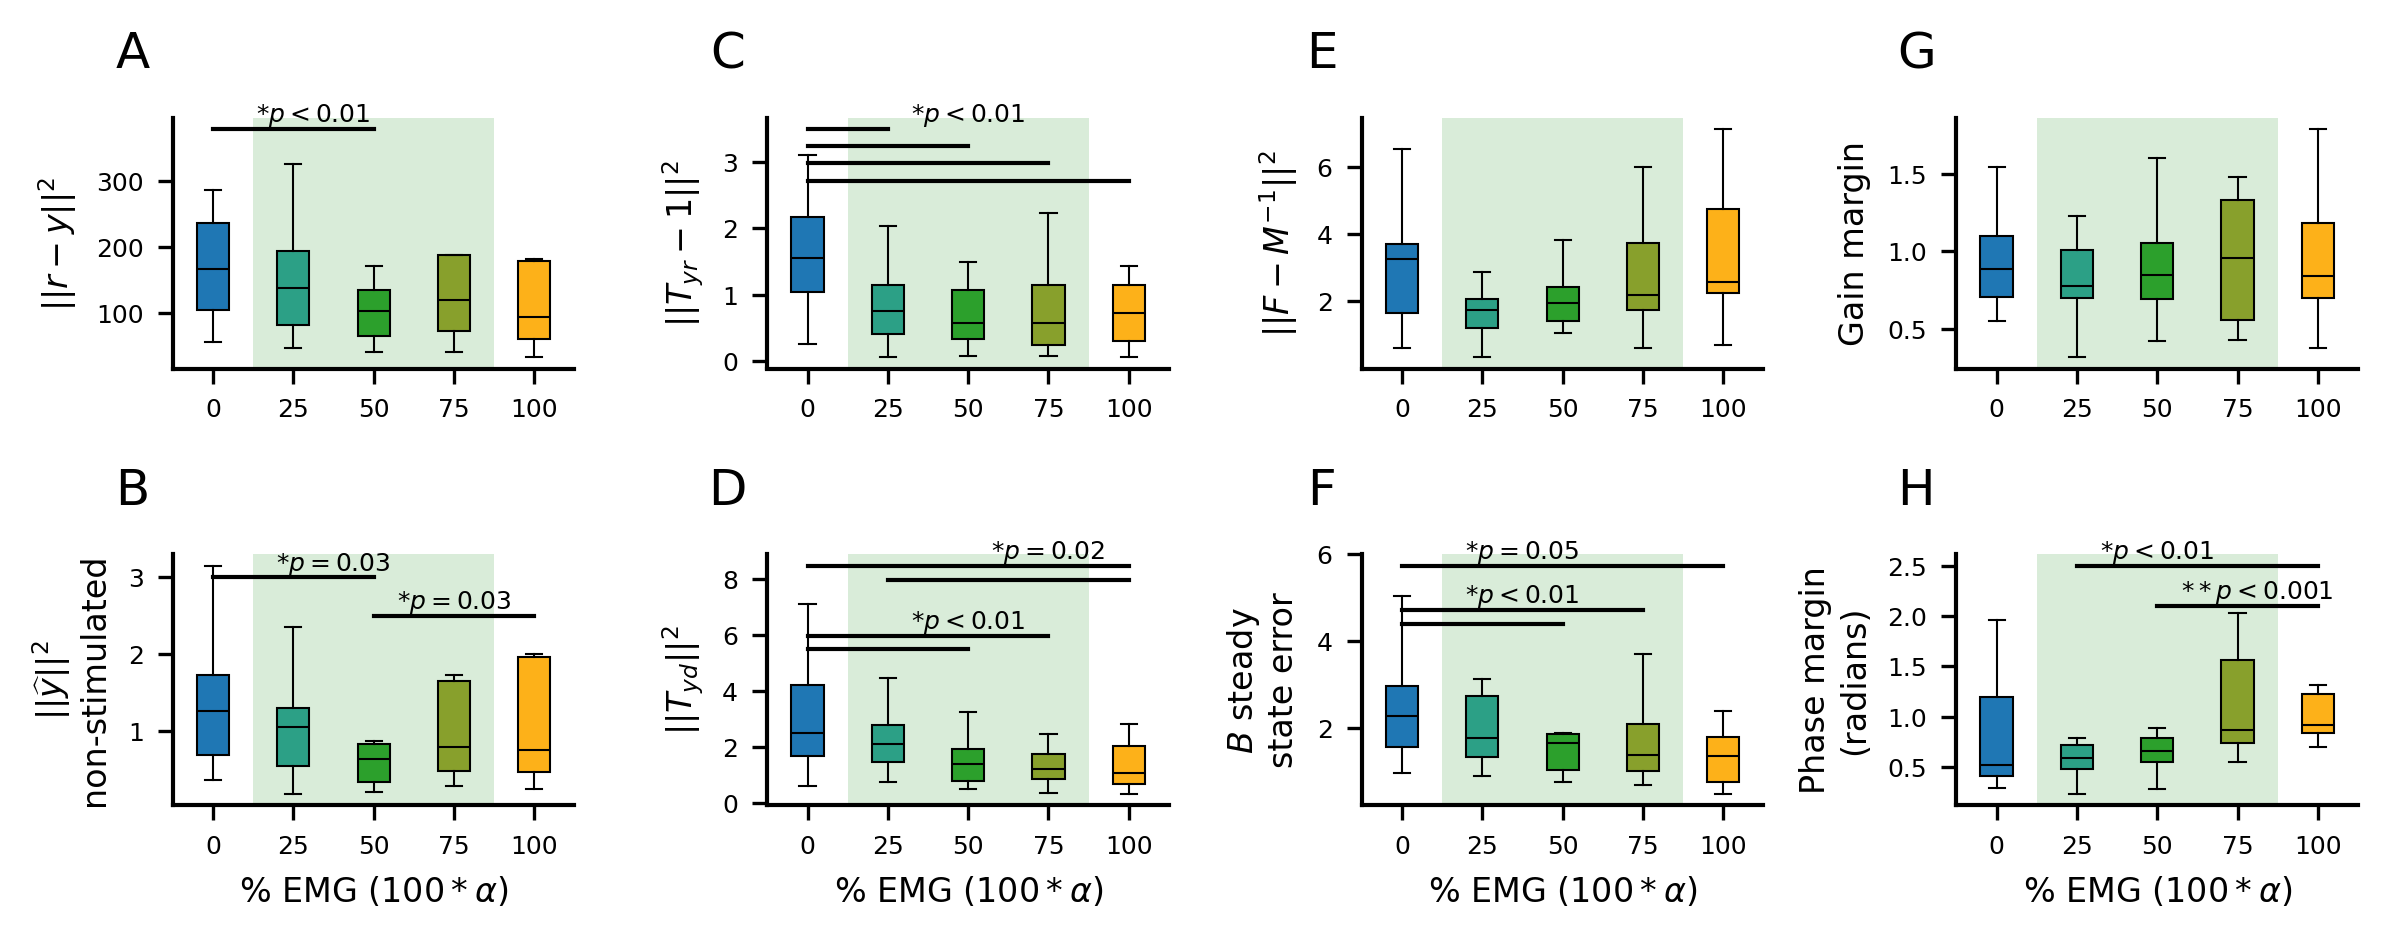

In [102]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

def boxplot(ax,datas):
    bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
    # ax.grid('on',zorder=-1)

fig,axs = plt.subplots(2,4,figsize=(8,3.2),dpi=300)
ax = axs[0,0]
datas = ALL[0]
boxplot(ax,datas)
ax.set_ylabel(r'$||r-y||^2$')
# larger_value = np.max([np.percentile(datas[0], 90),np.percentile(datas[2], 90)]) # significant difference
ax.plot([1, 3], [380,380], color='black')
ax.text(2.25, 380, r'$*p<0.01$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)

ax = axs[1,0]
datas = ALL[1]
boxplot(ax,datas)
ax.set_ylabel(r'$||\widehat{y}||^2$''\n''non-stimulated')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
larger_value = 3
ax.plot([1,3], [larger_value-0.0005,larger_value-0.0005], color='black')
ax.text(2.5, larger_value-0.0004, r'$*p=0.03$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)
larger_value = 2.5
ax.plot([3,5], [larger_value-0.0005,larger_value-0.0005], color='black')
ax.text(4, larger_value-0.0004, r'$*p=0.03$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)

ax = axs[0,1]
datas = ALL[2]
boxplot(ax,datas)
ax.set_ylabel(r'$||T_{yr} - 1||^2$')
larger_value = 3.5
ax.plot([1,2], [larger_value-0.0005,larger_value-0.0005], color='black')
ax.text(3, larger_value-0.0004, r'$*p<0.01$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)
larger_value = 3.25
ax.plot([1,3], [larger_value-0.01,larger_value-0.01], color='black')
larger_value = 3
ax.plot([1,4], [larger_value-0.02,larger_value-0.02], color='black')
larger_value = 2.75
ax.plot([1,5], [larger_value-0.03,larger_value-0.03], color='black')

ax = axs[1,1]
datas = ALL[3]
boxplot(ax,datas)
ax.set_ylabel(r'$||T_{yd}||^2$')
larger_value = 5.5
ax.plot([1,3], [larger_value-0.01,larger_value-0.01], color='black')
# ax.text(2, larger_value-0.01, r'$*p<0.01$', ha='center', va='bottom', fontsize=13, color='black')
larger_value = 6
ax.plot([1,4], [larger_value-0.02,larger_value-0.02], color='black')
ax.text(3, larger_value-0.02, r'$*p<0.01$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)
larger_value = 8.5
ax.plot([1,5], [larger_value-0.03,larger_value-0.03], color='black')
ax.text(4, larger_value-0.03, r'$*p=0.02$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)
larger_value = 8
ax.plot([2,5], [larger_value-0.03,larger_value-0.03], color='black')
# ax.text(4, larger_value-0.03, r'$*p=0.02$', ha='center', va='bottom', fontsize=13, color='black')

ax = axs[0,2]
datas = ALL[4]
boxplot(ax,datas)
ax.set_ylabel(r'$||F-M^{-1}||^2$')

ax = axs[1,2]
datas = ALL[5]
boxplot(ax,datas)
ax.set_ylabel(r'$B$'+' steady\nstate' +' error')
larger_value = 5.75
ax.plot([1,5], [larger_value-0.01,larger_value-0.01], color='black')
ax.text(2.5, larger_value-0.01, r'$*p=0.05$', ha='center', va='bottom', color='black',fontsize=TINY_SIZE)
larger_value = 4.4
ax.plot([1,3], [larger_value-0.01,larger_value-0.01], color='black')
# ax.text(2.5, larger_value-0.01, r'$*p<0.01$', ha='center', va='bottom', fontsize=13, color='black')
larger_value = 4.75
ax.plot([1,4], [larger_value-0.02,larger_value-0.02], color='black')
ax.text(2.5, larger_value-0.02, r'$*p<0.01$', ha='center', va='bottom',  color='black',fontsize=TINY_SIZE)

ax = axs[0,3]
datas = ALL[6]
boxplot(ax,datas)
ax.set_ylabel('Gain margin')

ax = axs[1,3]
datas = ALL[7]
boxplot(ax,datas)
ax.set_ylabel('Phase margin''\n''(radians)')
larger_value = 2.5
ax.plot([2, 5], [larger_value,larger_value], color='black')
ax.text(3, larger_value, r'$*p<0.01$', ha='center', va='bottom', color='black',fontsize=TINY_SIZE)
larger_value = 2.1
ax.plot([3, 5], [larger_value,larger_value], color='black')
ax.text(4.25, larger_value, r'$**p<0.001$', ha='center', va='bottom', color='black',fontsize=TINY_SIZE)

# titles = ['feedback error','R-Y at stim freqs','R-Y at nonstim freqs','F-M^-1','Phase margin','Gain margin']
titles = ['A','C','E','G','B','D','F','H']
k=0
for i in range(2):
    for j in range(4):
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)
        axs[1,j].set_xlabel(r'% EMG ($100*\alpha$)') #add x axis labels
        axs[i,j].set_title(titles[k],x = -0.1,y = 1.1,fontsize = BIGGER_SIZE)
        k+=1

plt.tight_layout()
# fig.savefig('performances.svg')
plt.show()

# Figure 3A - input boxplots

In [113]:
INPUTS_DATA = [INPUTS_ALL,INPUTS_NON_STIM]

C:\Users\amber\AppData\Local\Temp\ipykernel_81628\1933811103.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
C:\Users\amber\AppData\Local\Temp\ipykernel_81628\1933811103.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)


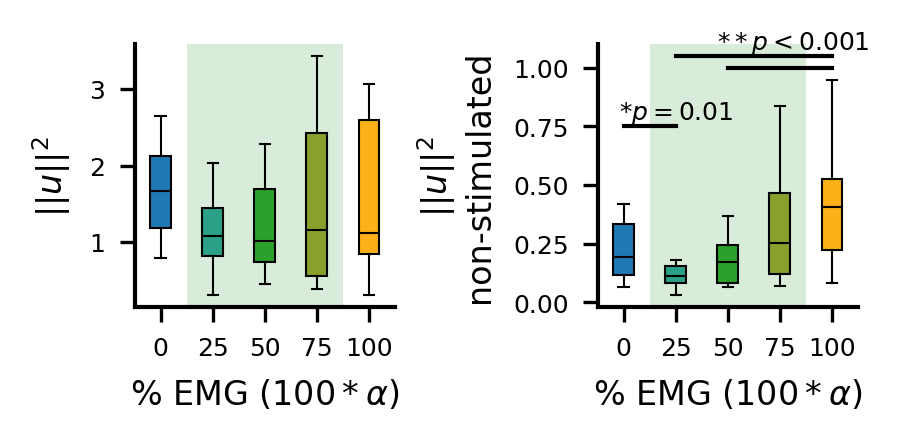

In [156]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

def boxplot(ax,datas):
    bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
    # ax.grid('on',zorder=-1)

fig,axs = plt.subplots(1,2,figsize=(3,1.5),dpi=300)

ax = axs[0]
datas = INPUTS_DATA[0]
boxplot(ax,datas)
ax.set_ylabel(r'$||u||^2$')

ax = axs[1]
datas = INPUTS_DATA[1]
boxplot(ax,datas)
ax.set_ylabel(r'$||u||^2$''\n''non-stimulated')
larger_value = 0.75
ax.plot([1,2], [larger_value,larger_value], color='black')
ax.text(2, larger_value, r'$*p=0.01$', ha='center', va='bottom', fontsize=TINY_SIZE, color='black')
larger_value = 1.05
ax.plot([2,5], [larger_value,larger_value], color='black')
ax.text(4.25, larger_value, r'$**p<0.001$', ha='center', va='bottom', fontsize=TINY_SIZE, color='black')
larger_value = 1
ax.plot([3,5], [larger_value,larger_value], color='black')

for i in range(2):
    # for j in range(5):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xlabel(r'% EMG ($100*\alpha$)') #add x axis labels

plt.tight_layout()
# fig.savefig('performances.svg')
plt.show()

# Figure 3B - input freqs

In [119]:
# crossover frequency for each subject
L = B * M 
# Find index along frequency axis where value is closest to 1
closest_idx = np.argmin(np.abs(np.abs(L) - 1), axis=-1)

print(closest_idx.shape)  # (15, 5, 7)

crossover_freqs = freqs[closest_idx]  # shape (15, 5, 7)

# find mean crossover frequency for each subject
mean_crossover_freqs = np.median(crossover_freqs, axis=(1,2))
mean_crossover_freqs

(15, 5, 7)


array([0.15, 0.15, 0.25, 0.15, 0.25, 0.35, 0.25, 0.25, 0.35, 0.15, 0.25,
       0.25, 0.25, 0.25, 0.25])

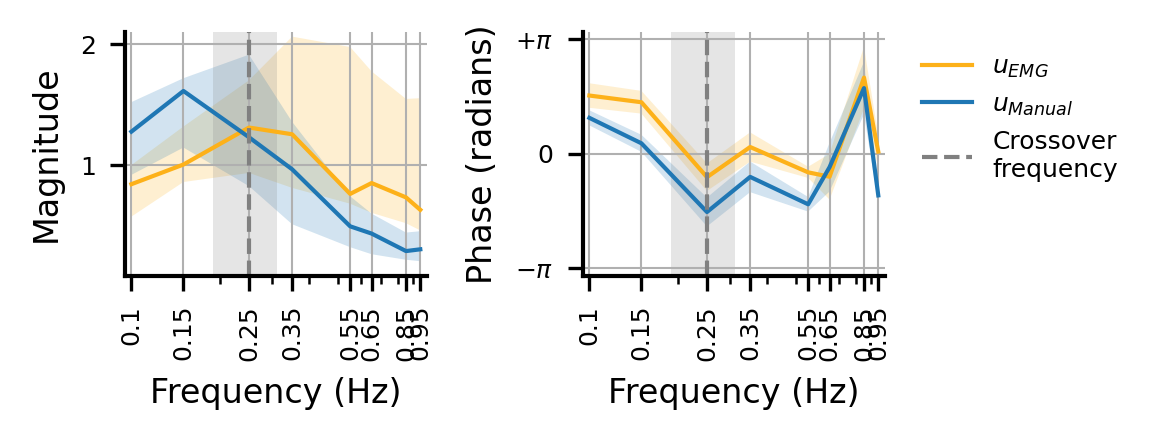

In [131]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylim = (0.09,2.1)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

cond = 2
last_trials = 10
fig,axs = plt.subplots(1,2,sharex=True,figsize=(4,1.5),dpi=300)

# magnitude
ax = axs[0]
# ax.axvline(x=0.25, color='grey', linestyle='--')
U0_mean = np.mean(np.abs(100*U0s[:,cond,-last_trials:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'EMG input',color = colors['GOLD'])
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'],edgecolor = None)

U1_mean = np.mean(np.abs(100*U1s[:,cond,-last_trials:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'Manual input',color = colors['BLUE'])
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'],edgecolor = None)

# ax.plot(freqs, 100*np.abs((1/M)*Stimuli),'--', label = 'Stimuli',color = 'black',linewidth = 3)
# cross over frequency
mean_cf = np.median(mean_crossover_freqs)
std_cf = np.std(mean_crossover_freqs)
ax.axvline(x=mean_cf, color='grey', linestyle='--')
ax.fill_betweenx(y=ylim, x1=mean_cf-std_cf, x2=mean_cf+std_cf, color='grey', alpha=0.2,edgecolor = None)

ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1,linewidth = 0.5)
ax.set_ylim(ylim)
# ax.set_yscale("log")
ax.set_ylabel('Magnitude')
ax.set_xlabel('Frequency (Hz)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# phase
ax = axs[1]
# ax.axvline(x=0.25, color='grey', linestyle='--')
angles = np.angle(np.mean(np.exp(1j*(np.angle(100*U0s[:,cond,-last_trials:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$u_{EMG}$',color = colors['GOLD'])
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'],edgecolor = None)

angles = np.angle(np.mean(np.exp(1j*(np.angle(100*U1s[:,cond,-last_trials:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles)), axis=0)
mean = np.angle(z)
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$u_{Manual}$',color = colors['BLUE'])
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'],edgecolor = None)

# cross over frequency
mean_cf = np.median(mean_crossover_freqs)
std_cf = np.std(mean_crossover_freqs)
ax.axvline(x=mean_cf, color='grey', linestyle='--',label = 'Crossover\nfrequency')
ax.fill_betweenx(y=ylimphase, x1=mean_cf-std_cf, x2=mean_cf+std_cf, color='grey', alpha=0.2,edgecolor = None)

ax.set_ylabel('Phase (radians)') 
ax.grid('on',zorder=-1,linewidth = 0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('Frequency (Hz)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)
plt.tight_layout()
plt.show()

# Figure 3C - UCM

In [136]:
# Machine inverse
M_all_inv = M_all**(-1)
M_all_inv[0] = 0
print(M_all_inv)

[ 0.        +0.j         -0.02467401+0.15707963j -0.09869604+0.31415927j
 ... -0.2220661 -0.4712389j  -0.09869604-0.31415927j
 -0.02467401-0.15707963j]


C:\Users\amber\AppData\Local\Temp\ipykernel_81628\2540635957.py:2: RuntimeWarning: invalid value encountered in reciprocal
  M_all_inv = M_all**(-1)


In [210]:
# stimulated
# trials = np.arange(0,trial_num)[-4:] # last 4 trials
last_few_trials = 10
indices = IX[:2] # indices below 0.25 Hz
# xdim = []
# ydim = []
# for cond in [1,2,3]: 
#     dim0 = []
#     dim1 = []
#     for sub in range(subject_num):
#         u0 = np.zeros((len(trials),N))
#         u1 = np.zeros((len(trials),N))
#         u0[:,indices] = 100*U0s[sub,cond,trials,:][:,indices] - \
#                                 100*((M_all_inv[indices]*(Rs[sub,cond,trials,:][:,indices]- \
#                                   Ys[sub,cond,trials,:][:,indices]))/(alphas[cond]))
#         u1[:,indices] = 100*U1s[sub,cond,trials,:][:,indices] - \
#                                 100*((M_all_inv[indices]*(Rs[sub,cond,trials,:][:,indices]- \
#                                   Ys[sub,cond,trials,:][:,indices]))/((1-alphas[cond])))
#         # conjegate symmetry
#         u0[:,-indices] = np.conjugate(u0[:,indices])
#         u1[:,-indices] = np.conjugate(u1[:,indices])
#         dim0.append( IFFT(u0,N) )
#         dim1.append( IFFT(u1,N) )
#     dim0 = np.array(dim0).flatten()
#     dim1 = np.array(dim1).flatten()
#     xdim.append(dim0)
#     ydim.append(dim1)
# xdim = np.array(xdim)
# ydim = np.array(ydim)    

#nonstimulated
indices = np.setdiff1d(np.arange(0,11), IX) # non-stimulus freqs below 0.25hz 
# indices = np.setdiff1d(np.arange(0,40), IX) # non-stimulus freqs below 1hz 
xdim_ = []
ydim_ = []
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N),dtype = complex)
        u1 = np.zeros((last_few_trials,N),dtype = complex)
        u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
        u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    xdim_.append(dim0)
    ydim_.append(dim1)
xdim_ = np.array(xdim_)
ydim_ = np.array(ydim_)   

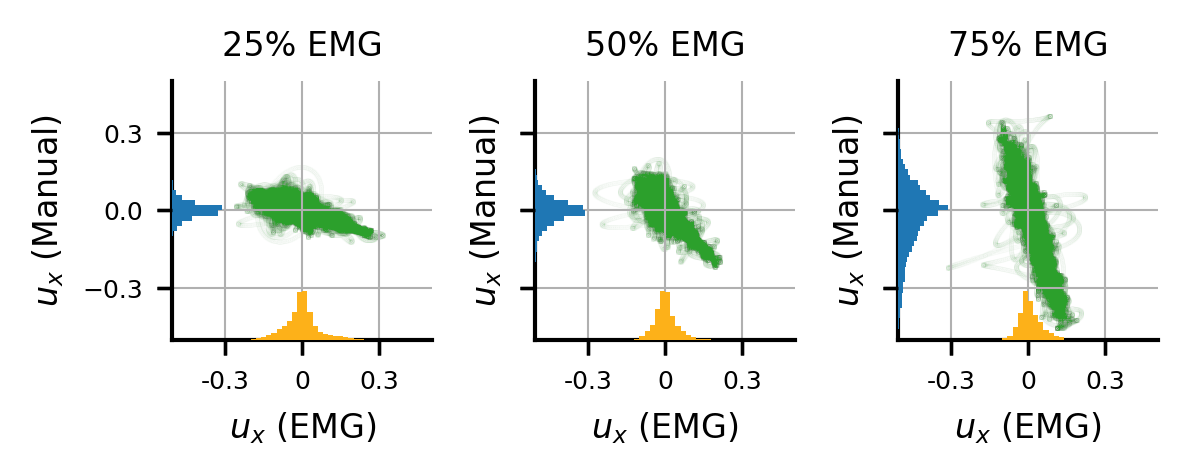

In [211]:
fig,axs = plt.subplots(1,3, sharex = True, sharey=True, figsize=(4,1.75),dpi = 300)

PLOT0 = xdim_
PLOT1 = ydim_
titles = ['25% EMG','50% EMG','75% EMG']
condition_order = [1,2,3]
# major_ticks = [-0.4,-0.2,0,0.2,0.4]
major_ticks = [-0.3,0,0.3]

# definitions for the axes
left, width = 0,1
bottom, height = 0,1
hist_height = 0.2 #historgram bin height
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom , width, hist_height]
rect_histy = [left, bottom, hist_height, height]

i = 0
for j in range(3): #cols
    ax = axs[j]
    ax.grid('on',zorder=-1,linewidth = 0.5)
    c = condition_order[j]
    x = np.array(PLOT0[j])
    y = np.array(PLOT1[j])
    # confidence_ellipse(x,y, ax, edgecolor='red')

    ax.scatter(x,y,color = colors['GREEN'], s=0.05,label = 'condition'+str(c),alpha = 0.01)

    #histograms
    ax_histx = ax.inset_axes(rect_histx, sharex=ax)
    ax_histy = ax.inset_axes(rect_histy, sharey=ax)
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # now determine nice limits by hand:
    binwidth = 0.02
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)
    if c != 5:
        ax_histx.hist(x, bins=bins,color=colors['GOLD'])
    if c != 6:
        ax_histy.hist(y, bins=bins, orientation='horizontal',color=colors['BLUE'])

    # ax.set_facecolor('none')
    ax_histx.set_facecolor('none')
    ax_histy.set_facecolor('none')

    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['bottom'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histy.spines['left'].set_visible(False)

    ax_histx.set(yticks=[])
    ax_histy.set(xticks=[])
    ax.set_aspect('equal')
    
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks) 
    
    ax.title.set_text(titles[j])
    ax.set_xlabel(r'$u_{x}$'+' (EMG)')
    ax.set_ylabel(r'$u_{x}$'+' (Manual)')
    # axs[j].set_xlim(-50,50)
    # axs[j].set_ylim(-50,50)
axs[0].set_yticks(major_ticks)
plt.tight_layout()
plt.show()

## VORT VUCM

In [246]:
#nonstimulated
indices = np.setdiff1d(np.arange(0,11), IX) # non-stimulus freqs below 0.25hz 
V_UCM = np.zeros((subject_num,condition_num))
V_ORT = np.zeros((subject_num,condition_num))
ydim_ = []
for cond in [1,2,3]:
    # projection vectors         
    if cond == 2:
        E_ORT = np.array([1,1])
        E_UCM = np.array([1,-1])
    elif cond == 1:
        E_ORT = np.array([1,3])
        E_UCM = np.array([3,-1])
    else: 
        E_ORT = np.array([3,1])
        E_UCM = np.array([1,-3])
    k = (np.linalg.norm(E_UCM))**2 #dimension of the subspace

    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N),dtype = complex)
        u1 = np.zeros((last_few_trials,N),dtype = complex)
        u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
        u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0 = IFFT(u0,N) 
        dim1 = IFFT(u1,N) 

        Sigma = np.cov(np.array([dim0.flatten(),dim1.flatten()])) # covariance matrix

        #variance at each direction
        variance_ucm = 1/k *(E_UCM.T@Sigma@E_UCM) #normalized by dimension of subspace
        variance_ort = 1/k *(E_ORT.T@Sigma@E_ORT)

        #variance in (UCM) and (OTH), variance across all trials and all freqs
        V_UCM[sub,cond] = variance_ucm
        V_ORT[sub,cond] = variance_ort

C:\Users\amber\AppData\Local\Temp\ipykernel_81628\3351762156.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box0 = ax.boxplot([V_ORT[:, 1], V_ORT[:, 2], V_ORT[:, 3]], positions=positions_A, widths=0.25, patch_artist=True,
C:\Users\amber\AppData\Local\Temp\ipykernel_81628\3351762156.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box1 = ax.boxplot([V_UCM[:, 1], V_UCM[:, 2], V_UCM[:, 3]], positions=positions_B, widths=0.25, patch_artist=True,


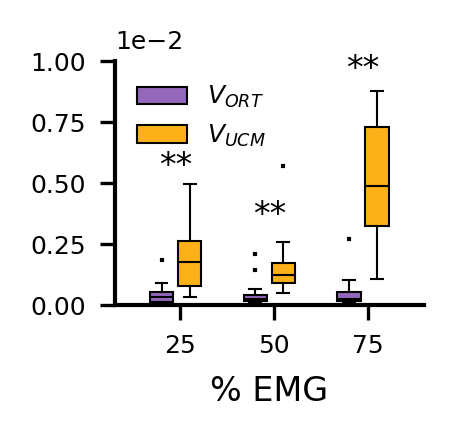

In [253]:
# Parameters
num_conditions = 3
positions_A = np.arange(num_conditions) * 1.0  # space out groups
positions_B = positions_A + 0.3                # small offset for side-by-side
box_colors = [colors['PURPLE'], colors['GOLD']]

# Plot
fig, ax = plt.subplots(1,1, figsize = (1.5,1.5), dpi=300)
box0 = ax.boxplot([V_ORT[:, 1], V_ORT[:, 2], V_ORT[:, 3]], positions=positions_A, widths=0.25, patch_artist=True,
            boxprops=dict(facecolor=box_colors[0]), medianprops=dict(color='black'), labels=['']*3, 
            flierprops={'marker': '+', 'markersize': 1})
box1 = ax.boxplot([V_UCM[:, 1], V_UCM[:, 2], V_UCM[:, 3]], positions=positions_B, widths=0.25, patch_artist=True,
            boxprops=dict(facecolor=box_colors[1]), medianprops=dict(color='black'), labels=['']*3,
            flierprops={'marker': '+', 'markersize': 1})

# X-axis setup
ax.set_xticks(positions_A + 0.2, ['25', '50', '75'])
ax.set_xlabel('% EMG')
# ax.set_ylabel('Value')
ax.legend(['A', 'B'], loc='upper right')
ax.legend([box0["boxes"][0], box1["boxes"][0]], 
          [r'$V_{ORT}$', r'$V_{UCM}$'], loc = 'upper left',ncol = 1, frameon = False)
ax.set_ylim(0,0.01)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))

ax.text(0.15, 0.005, r'**', ha='center', va='bottom', fontsize=SMALL_SIZE,color = 'k')
ax.text(1.15, 0.003, r'**', ha='center', va='bottom', fontsize=SMALL_SIZE,color = 'k')
ax.text(2.15, 0.009, r'**', ha='center', va='bottom', fontsize=SMALL_SIZE,color = 'k')


plt.tight_layout()
plt.show()

In [248]:
w,p3 = wilcoxon(V_ORT[:,1],V_UCM[:,1])
w,p2 = wilcoxon(V_ORT[:,2],V_UCM[:,2])
w,p4 = wilcoxon(V_ORT[:,3],V_UCM[:,3])
p3,p2,p4

(np.float64(0.00115966796875),
 np.float64(6.103515625e-05),
 np.float64(6.103515625e-05))

# Figure 3D - opposite

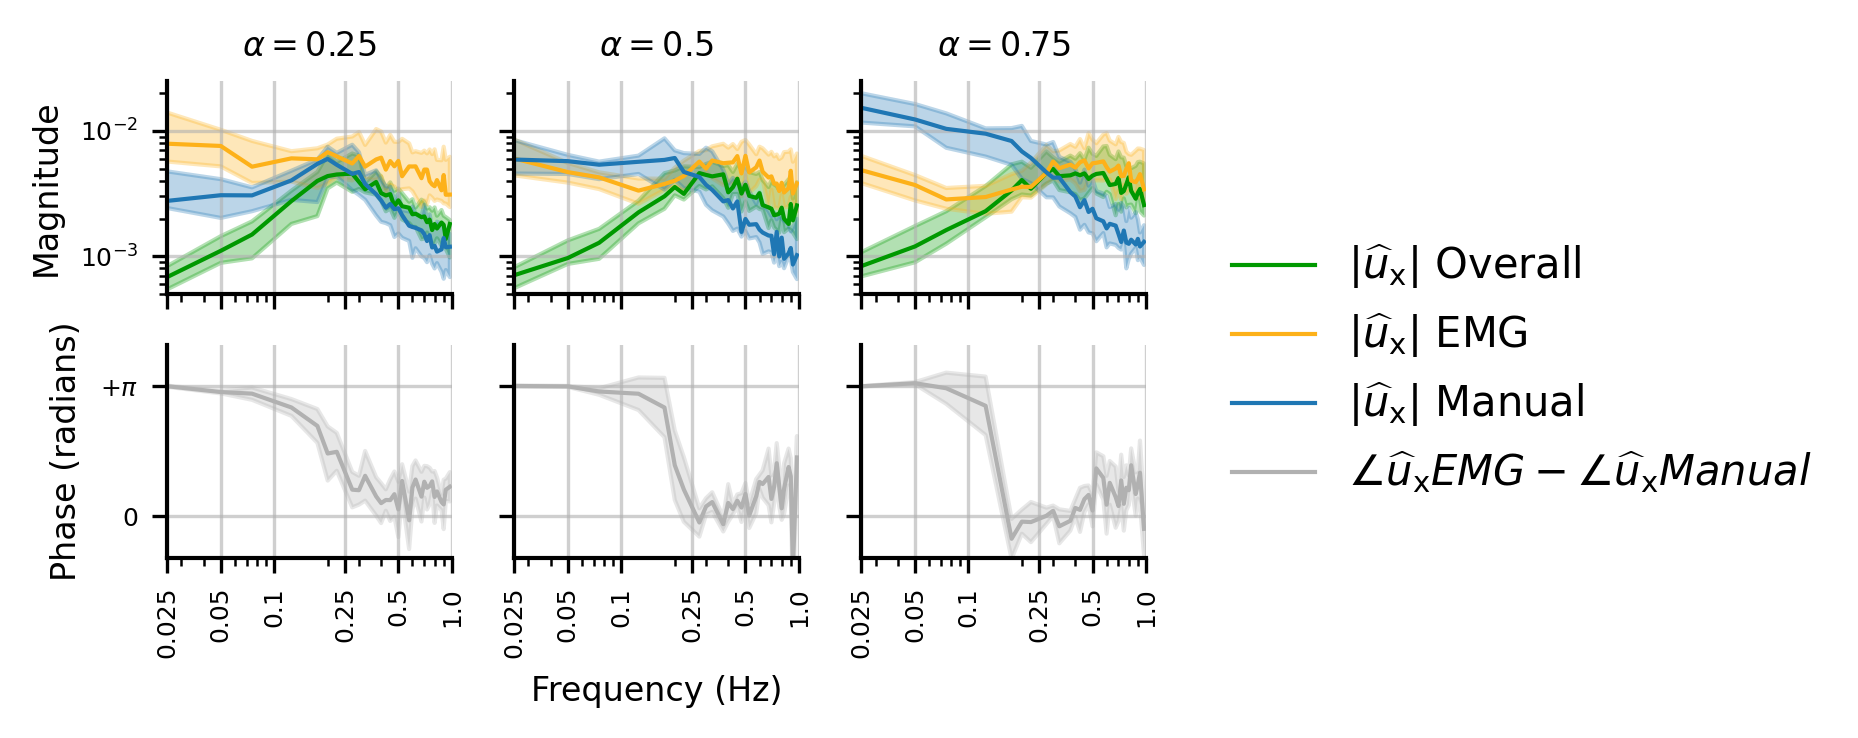

In [ ]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
nonstimulated_index = np.setdiff1d(np.arange(0,40), IX) # non-stimulus freqs below 1hz


fig,axs = plt.subplots(2, 3, sharex = 'col', sharey = 'row',figsize=(4,2.5), dpi=300)
j = 0
for c in [1,2,3]: #conditions
    # mag plots
    xlim = (0.025, 1.0)
    xticks = np.array([.025,.05,.1,.25,.5,1.])
    ylim = (0.5*1e-3,0.25*1e-1)
    yticks = [1e-2,1e-3]
    ytickslabels = [r'$10^{-2}$',r'$10^{-3}$']
    ylimphase = (-1,np.pi+1)
    yticksphase = [0.,np.pi]
    yticklabelsphase = [r'$0$',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['BLUE']]
    FillColors = [ufill,rfill,bfill,gfill]
    Labels = [r'$|\widehat{u}_{\mathrm{x}}|\ \mathrm{Overall}$',
              r'$|\widehat{u}_{\mathrm{x}}|\ \mathrm{EMG}$',
              r'$|\widehat{u}_{\mathrm{x}}|\ \mathrm{Manual}$'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0,j]
    UX_mean = []
    U0X_mean = []
    U1X_mean = []

    for sub in range(subject_num):
        #avg UX of one participant
        UX_mean.append( np.mean( np.abs(Us[sub,c,-last_trials:][:,nonstimulated_index]) ,axis = 0) ) 
        U0X_mean.append( np.mean( np.abs(U0s[sub,c,-last_trials:][:,nonstimulated_index]) ,axis = 0) )
        U1X_mean.append( np.mean( np.abs(U1s[sub,c,-last_trials:][:,nonstimulated_index]) ,axis = 0) )

    UX_mean_mean = np.percentile(UX_mean, 50, axis=0)
    U0X_mean_mean = np.percentile(U0X_mean, 50, axis=0)
    U1X_mean_mean = np.percentile(U1X_mean, 50, axis=0)

    UX_mean_25 = np.percentile(UX_mean, 25, axis=0)
    U0X_mean_25 = np.percentile(U0X_mean, 25, axis=0)
    U1X_mean_25 = np.percentile(U1X_mean, 25, axis=0)

    UX_mean_75 = np.percentile(UX_mean, 75, axis=0)
    U0X_mean_75 = np.percentile(U0X_mean, 75, axis=0)
    U1X_mean_75 = np.percentile(U1X_mean, 75, axis=0)

    ax.plot(xf[nonstimulated_index], UX_mean_mean , color=Colors[0])
    ax.plot(xf[nonstimulated_index], U0X_mean_mean , color=Colors[1])
    ax.plot(xf[nonstimulated_index], U1X_mean_mean , color=Colors[2])

    ax.fill_between(xf[nonstimulated_index], UX_mean_25, UX_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)
    ax.fill_between(xf[nonstimulated_index], U0X_mean_25, U0X_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    ax.fill_between(xf[nonstimulated_index], U1X_mean_25, U1X_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)

    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1,j]
    diff_phase_mean = []

    for sub in range(subject_num):
        diff_phase = []
        for i in range(10):
            diff_phase.append( np.angle(U0s[sub,c,-last_trials:][:,nonstimulated_index][i] /
                                U1s[sub,c,-last_trials:][:,nonstimulated_index][i]) )
        diff_phase_mean.append( np.angle( np.mean(np.exp(1j*np.asarray(diff_phase)), axis=0) ) )
        #circular stats
    # diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    # diff_phase_mean_mean = np.mean(np.exp(1j*diff_phase_mean), axis=0)
    # diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    # diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 
    z = np.mean(np.exp(1j*(np.asarray(diff_phase_mean)-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1-np.abs(z)

    ax.plot(xf[nonstimulated_index], mean , color=colors['g'],alpha = 1)
    ax.fill_between(xf[nonstimulated_index], mean+disp,mean-disp,
                        facecolor=FillColors[3],edgecolor=colors['g'],alpha = 0.3)

    ax = axs[0,j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale("log")
    ax.grid('on',zorder=-1,alpha = 0.6)
    # ax.tick_params(direction="in")
    
    ax = axs[1,j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.grid('on',zorder=-1,alpha = 0.6)
    # ax.tick_params(direction="in")

    j+=1
ax = axs[0,0]
ax.set_yticks(yticks)
ax.set_yticklabels(ytickslabels)
ax.plot([],[],color=Colors[0], label=Labels[0])
ax.plot([],[],color=Colors[1], label=Labels[1])
ax.plot([],[],color=Colors[2], label=Labels[2])
ax = axs[1,0]
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.plot([],[],color=colors['g'], label=r'$\angle{\widehat{u}_{\mathrm{x}} EMG} - \angle{\widehat{u}_{\mathrm{x}} Manual}$')
axs[0,0].title.set_text(r'$\alpha = 0.25$')
axs[0,1].title.set_text(r'$\alpha = 0.5$')
axs[0,2].title.set_text(r'$\alpha = 0.75$')
axs[1,1].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Magnitude') 
axs[1,0].set_ylabel('Phase (radians)')

fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',frameon=False,fontsize = MEDIUM_SIZE)
plt.tight_layout()
plt.show()